# 1 Introduction
This python notebook for Amazon food reviews polarity prediction based on the given review data by applying Naive Bayes algorithm which is based on Bayes probability model. To build generalized prediction model first step should be necessary cleaning of data as a part of data preprocessing. 

We will perform following data preprocessing. 

* Removing Stop-words
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Snowball Stemming the word 
* Convert the word to lowercase
 
Once we the data is cleaned to be processed we'll use below Feature generation techniques to convert text to numeric vector.
1. Bag Of Words (BoW)
1. Term Frequency - inverse document frequency (tf-idf)

Using Naive Bayes algorithm we will build model to predict review polarity for each technique. 

**Objective:** Given a review determine whether a review is positive or negative, by appling Naive Bayes algorithm and deciding the best Feature generation technique with most important features for positive & negative class. We will generate ROC curve for each model to check the sensibility of model

**Note:** As word2vec generate vector with negative valuel we can not use it for Naive Bays algorithm as it accepts positive values only as a imput vector.





**1.1 Load and check data**

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
# import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn

# import os
# print(os.listdir("../input"))


In [2]:
import sqlite3
# con = sqlite3.connect('../input/database.sqlite')

# filtered_data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""",con)
filtered_data = pd.read_csv('Reviews.csv')
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2 Data Preprocessing

*  **Segregating data as positive and negative**

In [3]:
# Here are replacing review score 1,2 as negative and 4,5 as a positive. we are skipping review score 3 considering it as a neutral.
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

* **Sorting data for time based splitting for model train and test dataset**

In [4]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.2,random_state=1) #0.055

finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.9,random_state=1) #0.25

final = pd.concat([finalp,finaln],axis=0)

#sording data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(118761, 10)


<AxesSubplot:>

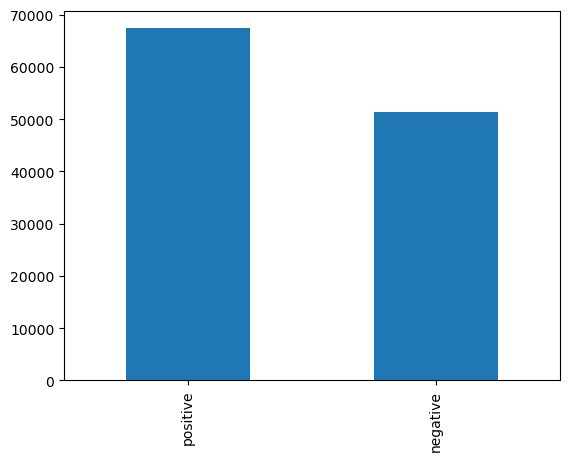

In [5]:
final['Score'].value_counts().plot(kind='bar')

* ** Removing Stop-words **
* ** Remove any punctuations or limited set of special characters like , or . or # etc. **
* ** Snowball Stemming the word ** 
* ** Convert the word to lowercase **

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\www/nltk_data'
    - 'C:\\Users\\www\\anaconda3\\nltk_data'
    - 'C:\\Users\\www\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\www\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\www\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


# 3 Building function to find optimal Alpha for Naive Bayes

**To Find the optimal alpha we will used cross validation method. Based on misclassifiction error for with different alpha, we will decide the best alpha on Train Data**

In [7]:
# from sklearn import cross_validation


def find_optimal_k(X_train,y_train, myList):
   
    # empty list that will hold cv scores
    cv_scores = []

    # split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

    for i in myList:
        nb = MultinomialNB(alpha = i)
        model = nb.fit(X_tr, y_tr)

        # predict the response on the crossvalidation train
        pred = model.predict(X_cv)

        # evaluate CV accuracy
        acc = accuracy_score(y_cv, pred, normalize=True)
        cv_scores.append(acc)
        
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = myList[MSE.index(min(MSE))]
    print('\nThe optimal alpha is ', optimal_alpha)


    plt.figure(figsize=(10,6))
    plt.plot(myList,MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. alpha Value')
    plt.xlabel('alpha')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_alpha


# 4 Feature generation techniques to convert text to numeric vector.[](http://) 

# 4.1 Appling Naive Bayes with BoW

**Generating Bag of Wrods Vector matrix for Reviews**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vect = CountVectorizer(ngram_range=(1,2) ) 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(final_string)#final['Text'].values)

NameError: name 'final_string' is not defined

In [9]:
from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )


NameError: name 'final_bow_count' is not defined

**Splitting Data into Train and Test based on the timestamp of review**

In [10]:
#We already have sorted data by timestamp so we will use first 70% of data as Train with cross validation and next 30% for test
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split


X = final_bow_np
y = final['Score']

X_train =  final_bow_np[:math.ceil(len(final)*.7)] 
X_test = final_bow_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

NameError: name 'final_bow_np' is not defined

**Finding Optimal alpha Cross validation**

In [11]:
from sklearn.naive_bayes import MultinomialNB

myList = np.arange(0.00001, 0.001, 0.00005) #list(range(1,200))
optimal_alpha = find_optimal_k(X_train ,y_train,myList)

print(optimal_alpha)

NameError: name 'X_train' is not defined

**Naive Bayes with Optimal alpha**

In [15]:
nb = MultinomialNB(alpha = optimal_alpha)
model = nb.fit(X_train, y_train)


NameError: name 'optimal_alpha' is not defined

In [16]:
predbow = (model.predict(X_test))

NameError: name 'model' is not defined

In [17]:
predbowprob = model.predict_proba(X_test)

NameError: name 'model' is not defined

In [18]:
skplt.plot_confusion_matrix(y_test ,predbow)

NameError: name 'skplt' is not defined

In [19]:
print(classification_report(y_test ,predbow))

NameError: name 'y_test' is not defined

In [20]:
print("Accuracy for Naive Bayes model with Bag of Words is ",round(accuracy_score(y_test ,predbow),3))

NameError: name 'y_test' is not defined

**Feature Importance**

In [21]:
bow_feat = count_vect.get_feature_names()

NotFittedError: Vocabulary not fitted or provided

In [22]:
y_train.value_counts()

NameError: name 'y_train' is not defined

In [23]:
model.class_count_ 

NameError: name 'model' is not defined

In [24]:
df = pd.DataFrame(model.feature_log_prob_,columns=bow_feat)
df1_transposed = df.T

NameError: name 'model' is not defined

In [25]:
fe_bow_neg = df1_transposed[0].sort_values(ascending = False)[0:10] ##Negative
fe_bow_pos =df1_transposed[1].sort_values(ascending = False)[0:10] ##Positive

NameError: name 'df1_transposed' is not defined

**Top 10 words found in Negative reviews with high probability**

In [26]:
fe_bow_neg

NameError: name 'fe_bow_neg' is not defined

**Top 10 words found in Positive reviews with high probability**

In [27]:
fe_bow_pos

NameError: name 'fe_bow_pos' is not defined

In [28]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_bow = label_binarize(y_test, classes= ["negative","positive","x"])[:,:-1]
n_classes = y_bow.shape[1]

NameError: name 'y_test' is not defined

In [29]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bow[:, i], predbowprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bow.ravel(), predbowprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

NameError: name 'n_classes' is not defined

# 4.2 Appling Naive Bayes with tf-idf

**Generating tf-idf Vector matrix for Reviews**

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_count = tf_idf_vec.fit_transform(final_string)#final['Text'].values)

#print(final_string)

NameError: name 'final_string' is not defined

In [31]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )


NameError: name 'final_tfidf_count' is not defined

**Splitting Data into Train and Test**

In [32]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_np
y = final['Score']

X_train =  final_tfidf_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]


NameError: name 'final_tfidf_np' is not defined

**Finding Optimal alpha Cross validation**

In [33]:
from sklearn.naive_bayes import MultinomialNB


myList = np.arange(0.00001, 0.001, 0.00005) #list(range(1,200))
optimal_alpha = find_optimal_k(X_train ,y_train,myList)

NameError: name 'X_train' is not defined

**Naive Bayes with Optimal alpha**

In [34]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(optimal_alpha)
model = nb.fit(X_train, y_train)


NameError: name 'optimal_alpha' is not defined

In [35]:
predtfidf = (model.predict(X_test))

NameError: name 'model' is not defined

In [36]:
predtfidfprob = (model.predict_proba(X_test))

NameError: name 'model' is not defined

In [37]:
skplt.plot_confusion_matrix(y_test ,predtfidf)

NameError: name 'skplt' is not defined

In [38]:
print(classification_report(y_test ,predtfidf))

NameError: name 'y_test' is not defined

In [39]:
print("Accuracy for Naive Bayes model with tf-id is ",round(accuracy_score(y_test ,predtfidf),3))

NameError: name 'y_test' is not defined

**Feature Importance**

In [40]:
tfidf_feat = tf_idf_vec.get_feature_names()

NotFittedError: Vocabulary not fitted or provided

In [41]:
y_train.value_counts()

NameError: name 'y_train' is not defined

In [42]:
df = pd.DataFrame(model.feature_log_prob_,columns=tfidf_feat)
df1_transposed = df.T
fe_tfidf_pos = df1_transposed[1].sort_values(ascending = False)[0:10] ##Positive
fe_tfidf_neg = df1_transposed[0].sort_values(ascending = False)[0:10] ##Negative

NameError: name 'model' is not defined

**Top 10 words found in Negative reviews with high probability**

In [43]:
fe_tfidf_neg

NameError: name 'fe_tfidf_neg' is not defined

**Top 10 words found in positive reviews with high probability**

In [44]:
fe_tfidf_pos

NameError: name 'fe_tfidf_pos' is not defined

# 5 Observation

**At the end of the Analysis we have two Naive Bayes model to compare with different Feature generation techniques, one with BoW and second with tf-idf. 
By comparing accuracy of models it's clear that both the model have almost equal accuracy more than 75%.**


In [45]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_tfidf = label_binarize(y_test, classes= ["negative","positive","x"])[:,:-1]
n_classes = y_tfidf.shape[1]

NameError: name 'y_test' is not defined

In [46]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_tfidf[:, i], predtfidfprob[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
# Compute micro-average ROC curve and ROC area
fpr2["micro"], tpr2["micro"], _ = roc_curve(y_tfidf.ravel(), predtfidfprob.ravel())
roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

# First aggregate all false positive rates
all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

from scipy import interp
# Then interpolate all ROC curves at this points
mean_tpr2 = np.zeros_like(all_fpr2)
for i in range(n_classes):
    mean_tpr2 += interp(all_fpr2, fpr2[i], tpr2[i])
    
# Finally average it and compute AUC
mean_tpr2 /= n_classes

fpr2["macro"] = all_fpr2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

NameError: name 'n_classes' is not defined

KeyError: 'micro'

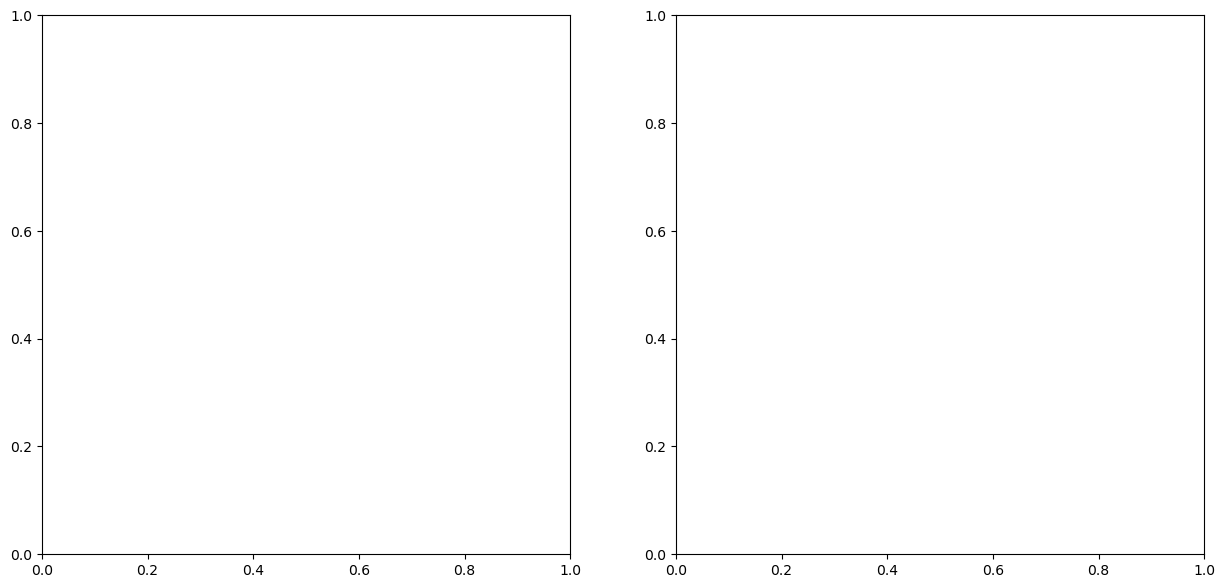

In [47]:
from itertools import cycle
lw = 2
f, (ax1 , ax2) = plt.subplots(1,2, sharex=True ,figsize=(15,7))
##axarr[1].figure(figsize=(10,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4, )

ax1.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
#ax1.axis([4, 8, 8, 20])
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.title.set_text('Bag Of Words (BoW)')
ax1.legend(loc="lower right")


ax2.plot(fpr2["micro"], tpr2["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax2.plot(fpr2["macro"], tpr2["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]))

ax2.plot([0, 1], [0, 1], 'k--', lw=lw)
# ax2.axis([4, 8, 8, 20])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
#ax2.set_ylabel('True Positive Rate')
ax2.title.set_text('Term Frequency - inverse document frequency (tf-idf)')

plt.suptitle('Receiver operating characteristic', fontsize=16)

ax2.legend(loc="lower right")



**ROC curve for both the model is sensible and indecates that both the model are equally powerful in terms of accuracy of prediction. AUC for the positive and negative reviews data point is more than 75% for both the model.**